# Efficient COCO Dataset Generator

This notebook was Inspired by [this](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data?scriptVersionId=77658860) great notebook. I made a few improvements in the `rle2mask` code to make it more efficient and used the functions provided in `pycocotools` to generate the json file. This results in massive reduction of compute time and dataset size.

What seemed at first to be a trivial task was a bit difficult as the RLE encoding used by COCO is very different from the encoding used in this comp.  

The comp encoding is rowise and every `odd` index represent the absolute begining of the mask. In the other hand, coco format expects it to be encoded by columns and the `odd` indexes are relative to the last end of the mask.

I couldn't find a trivial way to convert from those two formats without decoding the rle to mask, so the workflow is as folows:

1. Decode rle (competition) to binary mask
1. Encode the binary mask to rle (coco) using `pycocotools`
1. Save to `.json`

In [ ]:
while

In [12]:
%config Completer.use_jedi = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  """Entry point for launching an IPython kernel.


In [13]:
!pip install -Uqqq pycocotools

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from sklearn.model_selection import StratifiedKFold

## Loading the train dataframe

In [15]:
df = pd.read_csv('/content/drive/MyDrive/Kaggle/Sartorius/input/sartorius-cell-instance-segmentation/train.csv')
df.head()

id  ... elapsed_timedelta
0  0030fd0e6378  ...   0 days 11:30:00
1  0030fd0e6378  ...   0 days 11:30:00
2  0030fd0e6378  ...   0 days 11:30:00
3  0030fd0e6378  ...   0 days 11:30:00
4  0030fd0e6378  ...   0 days 11:30:00

[5 rows x 9 columns]

## Function that decodes rle (for this comp) to a binary mask

In [16]:
## Based on: https://www.kaggle.com/eigrad/convert-rle-to-bounding-box-x0-y0-x1-y1
def rle2mask(rle, img_w, img_h):
    
    ## transforming the string into an array of shape (2, N)
    array = np.fromiter(rle.split(), dtype = np.uint)
    array = array.reshape((-1,2)).T
    array[0] = array[0] - 1
    
    ## decompressing the rle encoding (ie, turning [3, 1, 10, 2] into [3, 4, 10, 11, 12])
    # for faster mask construction
    starts, lenghts = array
    mask_decompressed = np.concatenate([np.arange(s, s + l, dtype = np.uint) for s, l in zip(starts, lenghts)])

    ## Building the binary mask
    msk_img = np.zeros(img_w * img_h, dtype = np.uint8)
    msk_img[mask_decompressed] = 1
    msk_img = msk_img.reshape((img_h, img_w))
    msk_img = np.asfortranarray(msk_img) ## This is important so pycocotools can handle this object
    
    return msk_img

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(itertools.groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

## Minor Sanity Check

118145 6 118849 7 119553 8 120257 8 120961 9 121665 10 122369 12 123074 13 123778 14 124482 15 125186 16 125890 17 126594 18 127298 19 128002 20 128706 21 129410 22 130114 23 130818 24 131523 24 132227 25 132931 25 133635 24 134339 24 135043 23 135748 21 136452 19 137157 16 137864 11 138573 4


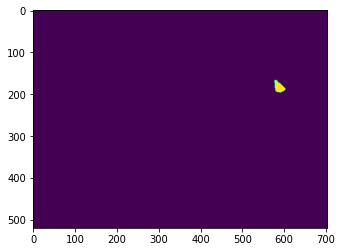

In [17]:
rle = df.loc[0, 'annotation']
print(rle)
plt.imshow(rle2mask(rle, 704, 520));

## Detect Broken Mask

In [22]:
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
import cv2
import matplotlib.pyplot as plt
TH = 40

def detect_broken_mask(mask):
  mask = ndi.binary_fill_holes(mask).astype(np.uint8)
  contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  c = contours[0][:, 0]
  diff = c - np.roll(c, 1, 0)
  targets = (diff[:, 1] == 0) & (np.abs(diff[:, 0]) >= TH)  # find horizontal lines longer than threshold

  if targets.sum() == 0:
      return 0
      
  if np.all(c[targets][:, 1] == 0) or np.all(c[targets][:, 1] == 519):  # remove screen edge cases
      return 0

  return 1

## Function that builds the .json file

In [34]:
from tqdm.notebook import tqdm
from pycocotools import mask as maskUtils
from joblib import Parallel, delayed

def annotate(idx, row, cat_ids):
    mask = rle2mask(row['annotation'], row['width'], row['height']) # Binary mask
    #iscrowd = detect_broken_mask(mask)
    c_rle = maskUtils.encode(mask) # Encoding it back to rle (coco format)
    c_rle['counts'] = c_rle['counts'].decode('utf-8') # converting from binary to utf-8
    area = maskUtils.area(c_rle).item() # calculating the area
    bbox = maskUtils.toBbox(c_rle).astype(int).tolist() # calculating the bboxes
    #c_rle = binary_mask_to_rle(mask)
    annotation = {
        'segmentation': c_rle,
        'bbox': bbox,
        'area': area,
        'image_id':row['id'], 
        'category_id':cat_ids[row['cell_type']], 
        'iscrowd':0, 
        'id':idx
    }
    return annotation
    
def coco_structure(df, workers = 4):
    
    ## Building the header
    # cat_ids = {name:id+1 for id, name in enumerate(df.cell_type.unique())}   
    # print(cat_ids) #
    cat_ids = {"shsy5y":1,"astro":2,"cort":3}   
    cats =[{'name':name, 'id':id} for name,id in cat_ids.items()]
    images = [{'id':id, 'width':row.width, 'height':row.height, 'file_name':f'train/{id}.png'} for id,row in df.groupby('id').agg('first').iterrows()]
    
    ## Building the annotations
    annotations = Parallel(n_jobs=workers)(delayed(annotate)(idx, row, cat_ids) for idx, row in tqdm(df.iterrows(), total = len(df)))
        
    return {'categories':cats, 'images':images, 'annotations':annotations}

## Running for the whole DF and saving it as a .json file

# KFold Genertation

In [35]:
train_df = pd.read_csv('/content/drive/MyDrive/Kaggle/Sartorius/input/sartorius-cell-instance-segmentation/train.csv')
train_meta = train_df.groupby('id').first().reset_index()

n_splits=5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2021)
for fold, (_, val_idx) in enumerate(skf.split(X=train_meta, y=train_meta['cell_type']), 1):
    # train_meta = train_meta.loc[val_idx,:].reset_index(drop=True)
    train_meta.loc[val_idx,"fold"] = fold


#train_meta = train_df[train_df.id.isin(train_meta.id.to_list())]

#train_meta.to_csv("/content/drive/MyDrive/Kaggle/Sartorius/input/fast test/train.csv",index=False)


# train_df = train_meta
# train_meta = train_meta.groupby('id').first().reset_index()
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
# for fold, (_, val_idx) in enumerate(skf.split(X=train_meta, y=train_meta['cell_type']), 1):
#     train_meta.loc[val_idx,"fold"] = fold 
    
train_meta['fold'] = train_meta['fold'].astype(np.uint8)
train_meta.groupby('fold').size()
train_meta[train_meta["fold"]!=5].groupby('cell_type').size()


cell_type
astro     105
cort      256
shsy5y    124
dtype: int64

In [43]:
for i in range(1,6):
    fold_selected=i # 1..5

    train_ids = train_meta[train_meta["fold"]!=fold_selected].id
    test_ids = train_meta[train_meta["fold"]==fold_selected].id

    df_train = train_df[train_df.id.isin(train_ids)]
    df_valid = train_df[train_df.id.isin(test_ids)]

    train_json = coco_structure(df_train)
    valid_json = coco_structure(df_valid)

    # with open(f'/content/drive/MyDrive/Kaggle/Sartorius/input/fixed_fold/coco_cell_train_fold{fold_selected}.json', 'w', encoding='utf-8') as f:
    #     json.dump(train_json, f, ensure_ascii=True, indent=4)

    # with open(f'/content/drive/MyDrive/Kaggle/Sartorius/input/fixed_fold/coco_cell_valid_fold{fold_selected}.json', 'w', encoding='utf-8') as f:
    #     json.dump(valid_json, f, ensure_ascii=True, indent=4)

{'shsy5y': 1, 'cort': 2, 'astro': 3}
{'astro': 1, 'cort': 2, 'shsy5y': 3}
{'shsy5y': 1, 'astro': 2, 'cort': 3}
{'cort': 1, 'shsy5y': 2, 'astro': 3}
{'astro': 1, 'cort': 2, 'shsy5y': 3}
{'shsy5y': 1, 'cort': 2, 'astro': 3}
{'shsy5y': 1, 'astro': 2, 'cort': 3}
{'cort': 1, 'astro': 2, 'shsy5y': 3}
{'shsy5y': 1, 'astro': 2, 'cort': 3}
{'cort': 1, 'shsy5y': 2, 'astro': 3}


In [41]:
import json,itertools
root = coco_structure(df)

{'shsy5y': 1, 'astro': 2, 'cort': 3}


In [ ]:
root['annotations'][0]

{'area': 498,
 'bbox': [576, 167, 27, 30],
 'category_id': 1,
 'id': 0,
 'image_id': '0030fd0e6378',
 'iscrowd': 0,
 'segmentation': {'counts': 'WeT97Q`0<D6J2N1O01O101N1O1O0010O01O1O1N2O1N2O1N2O1N2O1N2N2M_Sc1',
  'size': [520, 704]}}

In [ ]:
with open('annotations_train.json', 'w', encoding='utf-8') as f:
    json.dump(root, f, ensure_ascii=True, indent=4)

# Sanity check

In [ ]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [ ]:
dataDir=Path('../input/sartorius-cell-instance-segmentation')
annFile = Path('./annotations_train.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()

loading annotations into memory...
Done (t=1.03s)
creating index...
index created!


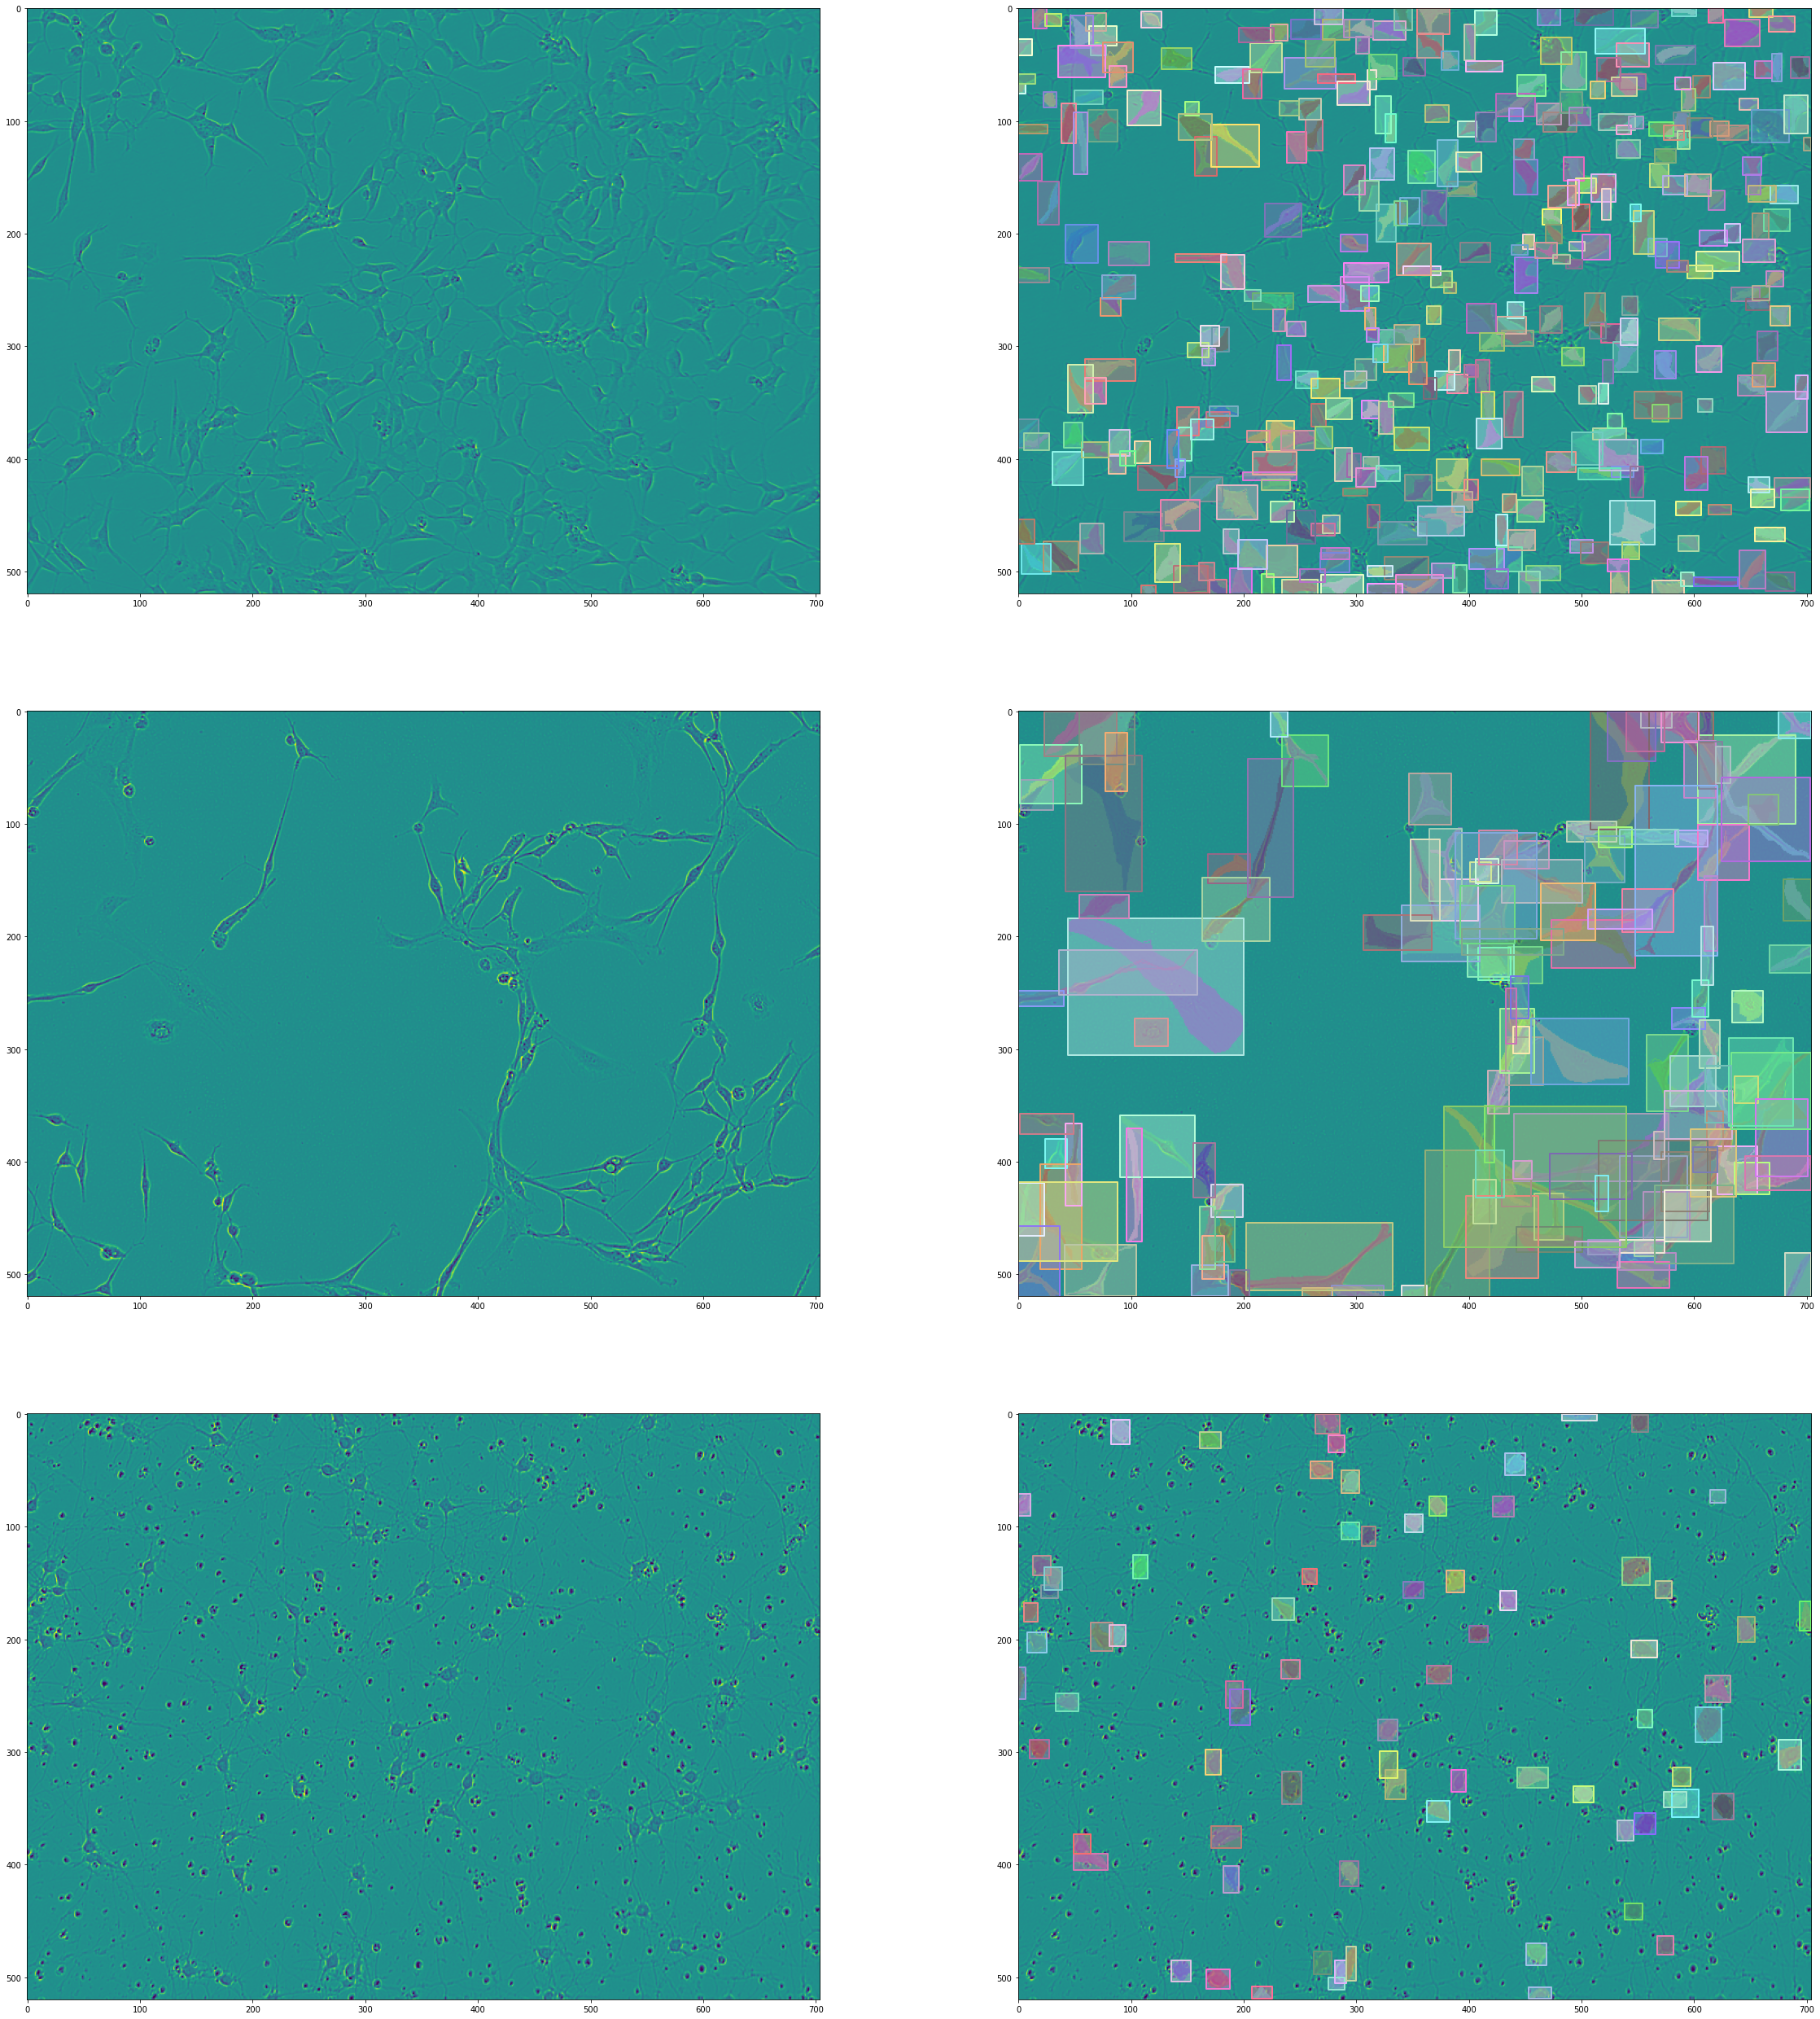

In [ ]:
imgs = coco.loadImgs(imgIds[-3:])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = Image.open(dataDir/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)